Q: How much more likely is certain preexisting conditions/symptoms to be related to high mortality? 

In [1]:
# Dependencies 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from sklearn import tree

# database 
import psycopg2
import config as creds

In [5]:
#connecting to database 
conn_string = "host="+ creds.PGHOST +" port="+ "5432" +" dbname="+ creds.PGDATABASE +" user=" + creds.PGUSER \
                  +" password="+ creds.PGPASSWORD
conn = psycopg2.connect(conn_string)

In [6]:
covid_df = pd.read_sql_query(
                   ''' SELECT * FROM coviddata 
                   ''' , conn)

In [7]:
covid_df

,id,country,provincestate,studypopsize,covidtest,meanage,male,whiteeuropean,africanamerican,asian,...,diarrhea,nauseavomiting,appetiteloss,sorethroatstuffynose,chills,chest_pain,smelltasteloss,nosymptoms,mortality,mortality_bin
0,ID ...,Country ...,Province/State ...,Study Pop Size (N) ...,Positive/negative cases ...,Mean Age ...,% Male ...,% White or European ...,% African American ...,% Asian ...,...,Diarrhoea ...,Nausea or Vomiting ...,Loss of Appetite/Anorexia ...,Sore Throat/Stuffy Nose ...,Chills ...,Chest Pain ...,Loss of smell/taste ...,Disease Severity Asymptomatic ...,Mortality ...,Mortality_bin ...
1,1 ...,China ...,Wuhan ...,191 ...,Positive only ...,56 ...,0.62 ...,0.0 ...,0.0 ...,1.0 ...,...,0.05 ...,0.04 ...,0.0 ...,0.0 ...,0.0 ...,0.0 ...,0.0 ...,0.0 ...,0.28 ...,1 ...
2,1 ...,China ...,Wuhan ...,54 ...,Positive only ...,69 ...,0.7 ...,0.0 ...,0.0 ...,1.0 ...,...,0.04 ...,0.06 ...,0.0 ...,0.0 ...,0.0 ...,0.0 ...,0.0 ...,0.0 ...,1.0 ...,1 ...
3,1 ...,China ...,Wuhan ...,137 ...,Positive only ...,52 ...,0.59 ...,0.0 ...,0.0 ...,1.0 ...,...,0.05 ...,0.03 ...,0.0 ...,0.0 ...,0.0 ...,0.0 ...,0.0 ...,0.0 ...,0.0 ...,0 ...
4,2 ...,China ...,Wuhan ...,199 ...,Positive only ...,58 ...,0.6 ...,0.0 ...,0.0 ...,1.0 ...,...,0.02 ...,0.04 ...,0.01 ...,0.0 ...,0.0 ...,0.0 ...,0.0 ...,0.0 ...,0.16 ...,1 ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1152,199 ...,China ...,Hubei ...,78 ...,Positive only ...,64 ...,0.65 ...,0.0 ...,0.0 ...,0.0 ...,...,0.03 ...,0.03 ...,0.0 ...,0.0 ...,0.0 ...,0.0 ...,0.0 ...,0.0 ...,0.13 ...,1 ...
1153,200 ...,USA ...,New York ...,151 ...,Positive only ...,56 ...,0.57 ...,0.0 ...,0.0 ...,0.0 ...,...,0.2 ...,0.09 ...,0.0 ...,0.11 ...,0.15 ...,0.0 ...,0.0 ...,0.0 ...,0.15 ...,1 ...
1154,200 ...,USA ...,New York ...,618 ...,Positive only ...,63 ...,0.57 ...,0.0 ...,0.0 ...,0.0 ...,...,0.25 ...,0.22 ...,0.0 ...,0.08 ...,0.19 ...,0.0 ...,0.0 ...,0.0 ...,0.13 ...,1 ...
1155,200 ...,USA ...,New York ...,231 ...,Positive only ...,62 ...,0.68 ...,0.0 ...,0.0 ...,0.0 ...,...,0.21 ...,0.1 ...,0.0 ...,0.08 ...,0.17 ...,0.0 ...,0.0 ...,0.0 ...,0.31 ...,1 ...


In [8]:
covid_df = covid_df.iloc[1:]


In [9]:
# # list for columns 
# my_list = covid_df.columns.values.tolist()
# my_list;

In [10]:
# grabbing relevant column names that contribute to covid risk factors 
column_names = ['meanage','male','smoking', 'hypertension', 'diabetes', 'cardiovasculardisease',
                'lungdisease', 'cancer', 'liverdisease', 'cerebrovasculardisease',
                'chronickidneydisease', 'otherconditions', 'fever', 'tachypnea',
                'cough', 'shortofbreath', 'headache', 'sputum', 'muscleaches',
                'fatigue', 'upperairwaycongestion', 'diarrhea', 'nauseavomiting', 'appetiteloss',
                'sorethroatstuffynose', 'chills', 'chest_pain', 'smelltasteloss', 'nosymptoms',
                'mortality_bin']
# df.columns = column_names

new_df = covid_df[column_names]
new_df

,meanage,male,smoking,hypertension,diabetes,cardiovasculardisease,lungdisease,cancer,liverdisease,cerebrovasculardisease,...,upperairwaycongestion,diarrhea,nauseavomiting,appetiteloss,sorethroatstuffynose,chills,chest_pain,smelltasteloss,nosymptoms,mortality_bin
1,56 ...,0.62 ...,0.06 ...,0.3 ...,0.19 ...,0.08 ...,0.03 ...,0.02 ...,0.0 ...,0.0 ...,...,0.0 ...,0.05 ...,0.04 ...,0.0 ...,0.0 ...,0.0 ...,0.0 ...,0.0 ...,0.0 ...,1 ...
2,69 ...,0.7 ...,0.09 ...,0.48 ...,0.31 ...,0.24 ...,0.07 ...,0.0 ...,0.0 ...,0.0 ...,...,0.0 ...,0.04 ...,0.06 ...,0.0 ...,0.0 ...,0.0 ...,0.0 ...,0.0 ...,0.0 ...,1 ...
3,52 ...,0.59 ...,0.04 ...,0.23 ...,0.14 ...,0.01 ...,0.01 ...,0.07 ...,0.0 ...,0.0 ...,...,0.0 ...,0.05 ...,0.03 ...,0.0 ...,0.0 ...,0.0 ...,0.0 ...,0.0 ...,0.0 ...,0 ...
4,58 ...,0.6 ...,0.0 ...,0.0 ...,0.12 ...,0.0 ...,0.0 ...,0.03 ...,0.0 ...,0.07 ...,...,0.0 ...,0.02 ...,0.04 ...,0.01 ...,0.0 ...,0.0 ...,0.0 ...,0.0 ...,0.0 ...,1 ...
5,59 ...,0.62 ...,0.0 ...,0.0 ...,0.1 ...,0.0 ...,0.0 ...,0.05 ...,0.0 ...,0.05 ...,...,0.0 ...,0.04 ...,0.1 ...,0.02 ...,0.0 ...,0.0 ...,0.0 ...,0.0 ...,0.0 ...,1 ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1152,64 ...,0.65 ...,0.0 ...,0.38 ...,0.21 ...,0.03 ...,0.0 ...,0.0 ...,0.0 ...,0.0 ...,...,0.0 ...,0.03 ...,0.03 ...,0.0 ...,0.0 ...,0.0 ...,0.0 ...,0.0 ...,0.0 ...,1 ...
1153,56 ...,0.57 ...,0.21 ...,0.5 ...,0.26 ...,0.11 ...,0.07 ...,0.03 ...,0.01 ...,0.0 ...,...,0.0 ...,0.2 ...,0.09 ...,0.0 ...,0.11 ...,0.15 ...,0.0 ...,0.0 ...,0.0 ...,1 ...
1154,63 ...,0.57 ...,0.23 ...,0.59 ...,0.38 ...,0.14 ...,0.07 ...,0.08 ...,0.02 ...,0.0 ...,...,0.0 ...,0.25 ...,0.22 ...,0.0 ...,0.08 ...,0.19 ...,0.0 ...,0.0 ...,0.0 ...,1 ...
1155,62 ...,0.68 ...,0.24 ...,0.68 ...,0.43 ...,0.13 ...,0.06 ...,0.06 ...,0.02 ...,0.0 ...,...,0.0 ...,0.21 ...,0.1 ...,0.0 ...,0.08 ...,0.17 ...,0.0 ...,0.0 ...,0.0 ...,1 ...


In [11]:
new_df=new_df.astype(str).astype(float)

In [12]:
new_df = new_df.rename(columns={"mortality_bin": "Mortality_bin"})

In [13]:
# assigning variables for Classifier Modeling
data = new_df.drop("Mortality_bin", axis=1)
feature_names = data.columns
target=new_df['Mortality_bin']
target_names=['low_risk','high_risk']

In [14]:
# split test/train data 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, target, random_state=1)

In [15]:
# Decision tree classifier returns 100% 
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)  
clf.score(X_test, y_test)

1.0

In [16]:
# Decision random forest classifier also returns 100% 
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=300)
rf = rf.fit(X_train, y_train)
rf.score(X_test, y_test)

1.0

In [17]:
# looking at feature importances
sorted(zip(rf.feature_importances_, feature_names), reverse=True) 

[(0.18319779906000747, 'diabetes'),
 (0.08065168026916218, 'hypertension'),
 (0.07596551410234265, 'chronickidneydisease'),
 (0.07312948304937791, 'meanage'),
 (0.07095129723320824, 'lungdisease'),
 (0.06487135061714323, 'cardiovasculardisease'),
 (0.04702196224443452, 'cancer'),
 (0.04648069087787865, 'male'),
 (0.04455780610954689, 'shortofbreath'),
 (0.03860893527582657, 'fever'),
 (0.03029291412230008, 'tachypnea'),
 (0.030010713763954516, 'cerebrovasculardisease'),
 (0.028858513751823998, 'cough'),
 (0.027176414314479688, 'diarrhea'),
 (0.024780884884134446, 'muscleaches'),
 (0.023449535786043016, 'fatigue'),
 (0.014511883881708211, 'nauseavomiting'),
 (0.014216335459847799, 'otherconditions'),
 (0.014158199514179624, 'smoking'),
 (0.013228345721836812, 'liverdisease'),
 (0.013014298005028943, 'sputum'),
 (0.011652447740000037, 'headache'),
 (0.009769621507072335, 'sorethroatstuffynose'),
 (0.00938126495711403, 'chest_pain'),
 (0.006050378836654203, 'appetiteloss'),
 (0.0019019079

In [20]:
# Grabbing top 6 underlying illness and symptoms and age/gender as factors based on feature importance
column_names = ['meanage','male','hypertension', 'diabetes', 'cardiovasculardisease',
                'lungdisease', 'cancer', 'chronickidneydisease', 'fever', 'tachypnea',
                'cough', 'shortofbreath',  'diarrhea',
                'fatigue',
                'Mortality_bin']
factors = pd.DataFrame(new_df,columns=column_names)
factors;


In [21]:
# assigning variables 
X = factors.drop('Mortality_bin', axis=1)
y = factors['Mortality_bin']

# split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,train_size=.80, random_state=1)


In [22]:
# importing logistic regression 
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(max_iter=300)
classifier


LogisticRegression(max_iter=300)

In [23]:
# fit training data 
classifier.fit(X_train, y_train)

LogisticRegression(max_iter=300)

In [24]:
# classifier score 
print(f"Training Data Score: {classifier.score(X_test, y_test)}")

Training Data Score: 0.875


In [25]:
# using classifier for predictions
predictions = classifier.predict(X_test)
result=pd.DataFrame({"Prediction": predictions, "Actual": y_test}).head(25)
result;

In [26]:
# printing f-score in classification report 
from sklearn.metrics import classification_report
print(classification_report (y_test, predictions, target_names = ['low risk','high risk']))

              precision    recall  f1-score   support

    low risk       0.92      0.93      0.92       188
   high risk       0.67      0.66      0.67        44

    accuracy                           0.88       232
   macro avg       0.80      0.79      0.79       232
weighted avg       0.87      0.88      0.87       232



In [27]:
# printing classification report as csv file 
report = classification_report (y_test, predictions, target_names = ['low risk','high risk'],output_dict=True)
class_report=pd.DataFrame(report).transpose()
class_report
# class_report.to_csv('../static/pltImages/classificationReport.csv')

,precision,recall,f1-score,support
low risk,0.920635,0.925532,0.923077,188.000
high risk,0.674419,0.659091,0.666667,44.000
accuracy,0.875000,0.875000,0.875000,0.875
macro avg,0.797527,0.792311,0.794872,232.000
weighted avg,0.873939,0.875000,0.874447,232.000


In [28]:
# from sklearn import metrics
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test, predictions, labels = [0,1])
matrix

array([[174,  14],
       [ 15,  29]])

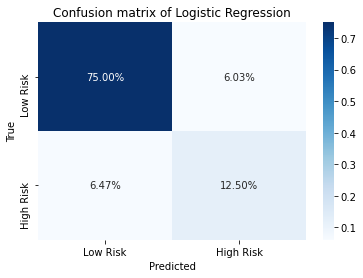

In [29]:
# confusion matrix with % break down 
import seaborn as sns
ax = plt.subplot()
# labels = ['Low Risk','High Risk']
# categories = ['lowrisk',' highrisk']
sns.heatmap(matrix/np.sum(matrix), annot=True, 
            fmt='.2%', cmap='Blues', ax=ax)
ax.set_title('Confusion matrix of Logistic Regression')
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.xaxis.set_ticklabels(['Low Risk','High Risk']); ax.yaxis.set_ticklabels(['Low Risk','High Risk']);

plt.savefig('../static/pltImages/confusionMatrix.png');


<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

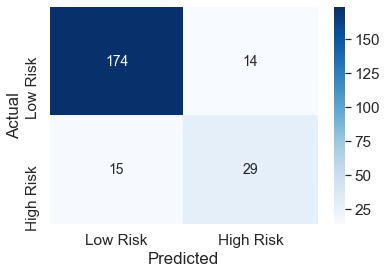

In [30]:
# confusion matrix with values 
labels = ['Low Risk','High Risk']
data = confusion_matrix(y_test,predictions)
data_df = pd.DataFrame(data, columns=labels, index = labels)
data_df.index.name = 'Actual'
data_df.columns.name = 'Predicted'
# plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(data_df, cmap="Blues", annot=True, fmt='g',annot_kws={"size": 14})# font size

Test calculator 

In [31]:
list(factors)

['meanage',
 'male',
 'hypertension',
 'diabetes',
 'cardiovasculardisease',
 'lungdisease',
 'cancer',
 'chronickidneydisease',
 'fever',
 'tachypnea',
 'cough',
 'shortofbreath',
 'diarrhea',
 'fatigue',
 'Mortality_bin']

In [32]:
# testing new patient data 
new_patient = [26,1,0,1,0,0,0,0,1,0,0,0,0,0]


In [33]:
data = np.array([new_patient]) 
predictions = classifier.predict(data)
predictions

array([1.])

In [34]:
# saving model to file 
import pickle
filename='../LogisticRegression/predictorRisk2.sav'
pickle.dump(classifier, open(filename,'wb'))